# Houses Price Prediction

En este proyecto, el objetivo es realizar una exploración de datos y modelar con regressión lineal para predecir los precios de un conjunto de propiedades. El presente Notebook en Jupyter busca realizar un preprocesamiento de los datos, limpieza y transformación para tener obtener un DataFrame listo para su modelado.

Adicionalmente, se visualizará el estado de los datos, la interrelación de las variables, sus estadísticos básicos y un proceso de normalización adecuado.

Se guardarán los modelos entrenados en un directorio para su uso sin necesidad de reentrenamiento al igual que la instancia de normalización de datos. 

Finalmente, en el directorio `data/` estará disponible tanto la data cruda y sin procesar como la data procesada. 

In [24]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

tqdm.pandas()
plt.style.use('ggplot')
np.random.seed(2022)

## 1. Carga de Datos

Cargamos los datos crudos desde el directorio `data/` en un objeto DataFrame.

In [25]:
# Load Data 
data = pd.read_csv('../data/raw_data.csv', delimiter = ';')
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,13/10/2014,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,9/12/2014,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,25/2/2015,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,9/12/2014,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,18/2/2015,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


Vemos la forma del data frame

In [26]:
# Shape of DataFrame
print("N° Rows: {} \nN° Features: {}".format(data.shape[0], data.shape[1]))

N° Rows: 21597 
N° Features: 21


Vemos el tipo de datos y la cantidad de variables con el número de valores no nulos y el tipo de dato. 

In [27]:
# General Info of DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

Finalmente, visualizamos estadísticos básicos de los datos.

In [28]:
# Describe Features continuos
data.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,5.402966e+05
std,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950,3.673681e+05
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3.220000e+05
50%,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


## 2. Análisis Exploratorio de Datos (EDA)

La finalidad es examinar los datos previamente a la aplicación de cualquier técnica estadística. El objetivo es conseguir un entendimiento base de los datos y las relaciones existentes entre las variables.

### 2.1 Examen Gráfico

Realizamos un examen gráfico de las principales variables. En este caso, las vamos a comparar con la variable objetivo `sales`. Veamos como está el comportamiento.

#### Variables vs Objetivo

Se aprovecha la oportunidad de econtrar una ubicación mas intuitiva de cada propiedad. Utilizando la librería `Geopy`, podemos acceder a un servicio mediante API realizando peticiones mediante el ZipCode y saber en que ciudad se encuentra ubicado el inmueble.

Documentación: [Geopy](https://geopy.readthedocs.io/en/stable/)

In [29]:
# Group by for Zipcode
group_zipcode = pd.DataFrame(data.groupby(['zipcode'])['zipcode'].count())\
                            .rename({'zipcode':'count'}, axis = 1).reset_index()
group_zipcode.sort_values(by = ['count'], ascending=False, inplace=True)

# instance of Nominatim
geoLoc = Nominatim(user_agent='geoLoc', timeout=10)
# We care of number request to server with a RateLimiter.
geoCode = RateLimiter(geoLoc.geocode, min_delay_seconds=0.0, max_retries = 2,
                        error_wait_seconds = 2.0, swallow_exceptions=True, 
                        return_value_on_exception=None)

# apply discret function lambda in zipcode city
group_zipcode['city'] = group_zipcode['zipcode']\
                        .progress_apply(lambda x: geoCode(query = {'country': 'United States of America', 'postalcode': x})\
                        .raw['display_name'].split(', ')[0])

# group_zipcode['county'] = group_zipcode['zipcode']\
#                         .progress_apply(lambda x: geoCode(query = {'country': 'United States of America', 'postalcode': x})\
#                         .raw['display_name'].split(', ')[1])


# ZipCode as Index
group_zipcode.set_index('zipcode', inplace=True)

100%|██████████| 70/70 [00:35<00:00,  1.95it/s]


Migramos la data al DataFrame original creando un nuevo campo como `city`.

In [30]:
# Migrating values to Data
def search_city(data, zipcode:int) -> str:
    return data['city'][zipcode]

data['city'] = data['zipcode'].progress_apply(lambda x: search_city(group_zipcode, x))

data.sample(4)

100%|██████████| 21597/21597 [00:00<00:00, 112713.13it/s]


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,city
15135,9406510130,5/5/2015,5,3.50,3740,24684,2.0,0,0,3,...,980,1998,0,98038,47.3832,-122.057,2880,26023,448000,Maple Valley
8813,1782500035,3/7/2014,2,1.00,870,4600,1.0,0,0,4,...,0,1942,0,98126,47.5274,-122.379,930,4600,357000,Seattle
16113,3818700190,15/12/2014,4,1.75,2520,15205,1.0,0,0,4,...,480,1954,0,98028,47.7642,-122.264,1680,10000,387846,Kenmore
12901,930000234,21/4/2015,4,2.00,2260,7680,1.0,0,0,4,...,1130,1947,0,98177,47.7193,-122.361,1800,7680,525000,Seattle


In [31]:
# USD/sqft
df_plot = data.copy()
df_plot['usd_sqft'] = data['price']/data['sqft_lot15']
df_plot.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,city,usd_sqft
0,7129300520,13/10/2014,3,1.00,1180,5650,1.0,0,0,3,...,1955,0,98178,47.5112,-122.257,1340,5650,221900,King County,39.274336
1,6414100192,9/12/2014,3,2.25,2570,7242,2.0,0,0,3,...,1951,1991,98125,47.7210,-122.319,1690,7639,538000,Seattle,70.428067
2,5631500400,25/2/2015,2,1.00,770,10000,1.0,0,0,3,...,1933,0,98028,47.7379,-122.233,2720,8062,180000,Kenmore,22.326966
3,2487200875,9/12/2014,4,3.00,1960,5000,1.0,0,0,5,...,1965,0,98136,47.5208,-122.393,1360,5000,604000,Seattle,120.800000
4,1954400510,18/2/2015,3,2.00,1680,8080,1.0,0,0,3,...,1987,0,98074,47.6168,-122.045,1800,7503,510000,Sammamish,67.972811


In [32]:
# Group by for city
group_city = pd.concat([df_plot.groupby(['city'])['price'].mean(), 
                        df_plot.groupby(['city'])['city'].count(),
                        df_plot.groupby(['city'])['sqft_lot15'].mean(),
                        df_plot.groupby(['city'])['usd_sqft'].mean()], axis=1)
group_city.rename({'city':'count'}, axis = 1, inplace = True)
group_city.reset_index(inplace = True)
group_city.sort_values(by = 'count', ascending = False, inplace = True)

Ahora podemos visualizar el precio medio por ciudad. 

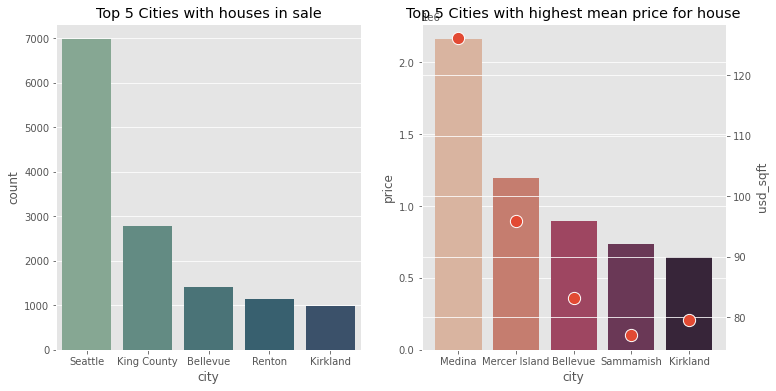

In [33]:
# Create Canvas
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize = (12, 6))

sns.barplot(x = 'city', y = 'count', data = group_city.sort_values(['count'], ascending = False).head(5), 
            palette = 'crest', saturation=.5, ax = ax1)

sns.barplot(x = 'city', y = 'price', data = group_city.sort_values(['price'], ascending = False).head(5), 
            palette = 'rocket_r', saturation=.5, ax = ax2)

ax2_2 = ax2.twinx()
sns.scatterplot(x = 'city', y = 'usd_sqft', s = 150, data = group_city.sort_values(['price'], ascending = False).head(5), 
                palette = 'viridis', marker = 'o', ax = ax2_2)

ax1.set_title('Top 5 Cities with houses in sale')
ax2.set_title('Top 5 Cities with highest mean price for house')

plt.show()

Podemos observar que Seattle es claramente la ciudad del estado de Washington con mayor cantidad de inmuebles, a su vez su precio por pie cuadrado es el mas alto. Bellevue tiene precios más altos debido a que los inmuebles son mas grande en pie cuadrados. 

Análicemos el resto de las variables disponibles en el dataset. Podemos comparar variables estratégicas cómo:
* `grade`: Clasificación general de la vivienda (1 - 13)(pobre - excelente).
* `condition`: En que condiciones está la vivienda **1** desgastada → **5** excelente.
* `waterfront`: Si la vivienda tiene vista al mar (boolean).
* `floors`: Número de pisos. Existen valores decimales, es posible que se traten de pisos parciales.
* `view`: Cantidad de vista
* `bathrooms`: Cantidad de baños
* `betrooms`: Cantidad de habitaciones
* `year_build`: Año construido
* `yr_renovated`: Año de renovación
* `sqft_living`: Tamaño en pies cuadrados del living. Existe una medida actualizada en 2015 a raiz de renovaciones
* `sqft_lot`: Tamaño en pies cuadrados totales. Existe una medida actualizada en 2015 a raiz de renovaciones

Realizamos una regresion lineal simple para sqft_living como variable independiente `x` y price para la variable dependiente.

$
f(x) = \alpha + \sum_{j=1}^{n}\beta_{j}X_{i}
$

De forma generalizada:
 
$
f(x) = \alpha + \beta_{0}X
$

In [34]:
# Linear Regression of Scikit-Learn
lr = LinearRegression(fit_intercept = True)
X = np.array(df_plot['sqft_living']).reshape((len(df_plot),1))
y = np.array(df_plot['price']).reshape((len(df_plot),1))

# Training
lr.fit(X, y)

# Line test
x = np.linspace(0, X.max())
x = x.reshape((len(x),1))
y_predict = lr.predict(x)[:,0]

# coef and intercept point
beta = round(lr.coef_[0][0], 2)
alpha = round(lr.intercept_[0], 2)

ecu = "$f(x) = $" + str(alpha) + "$ + $" + str(beta) + "$X$" 

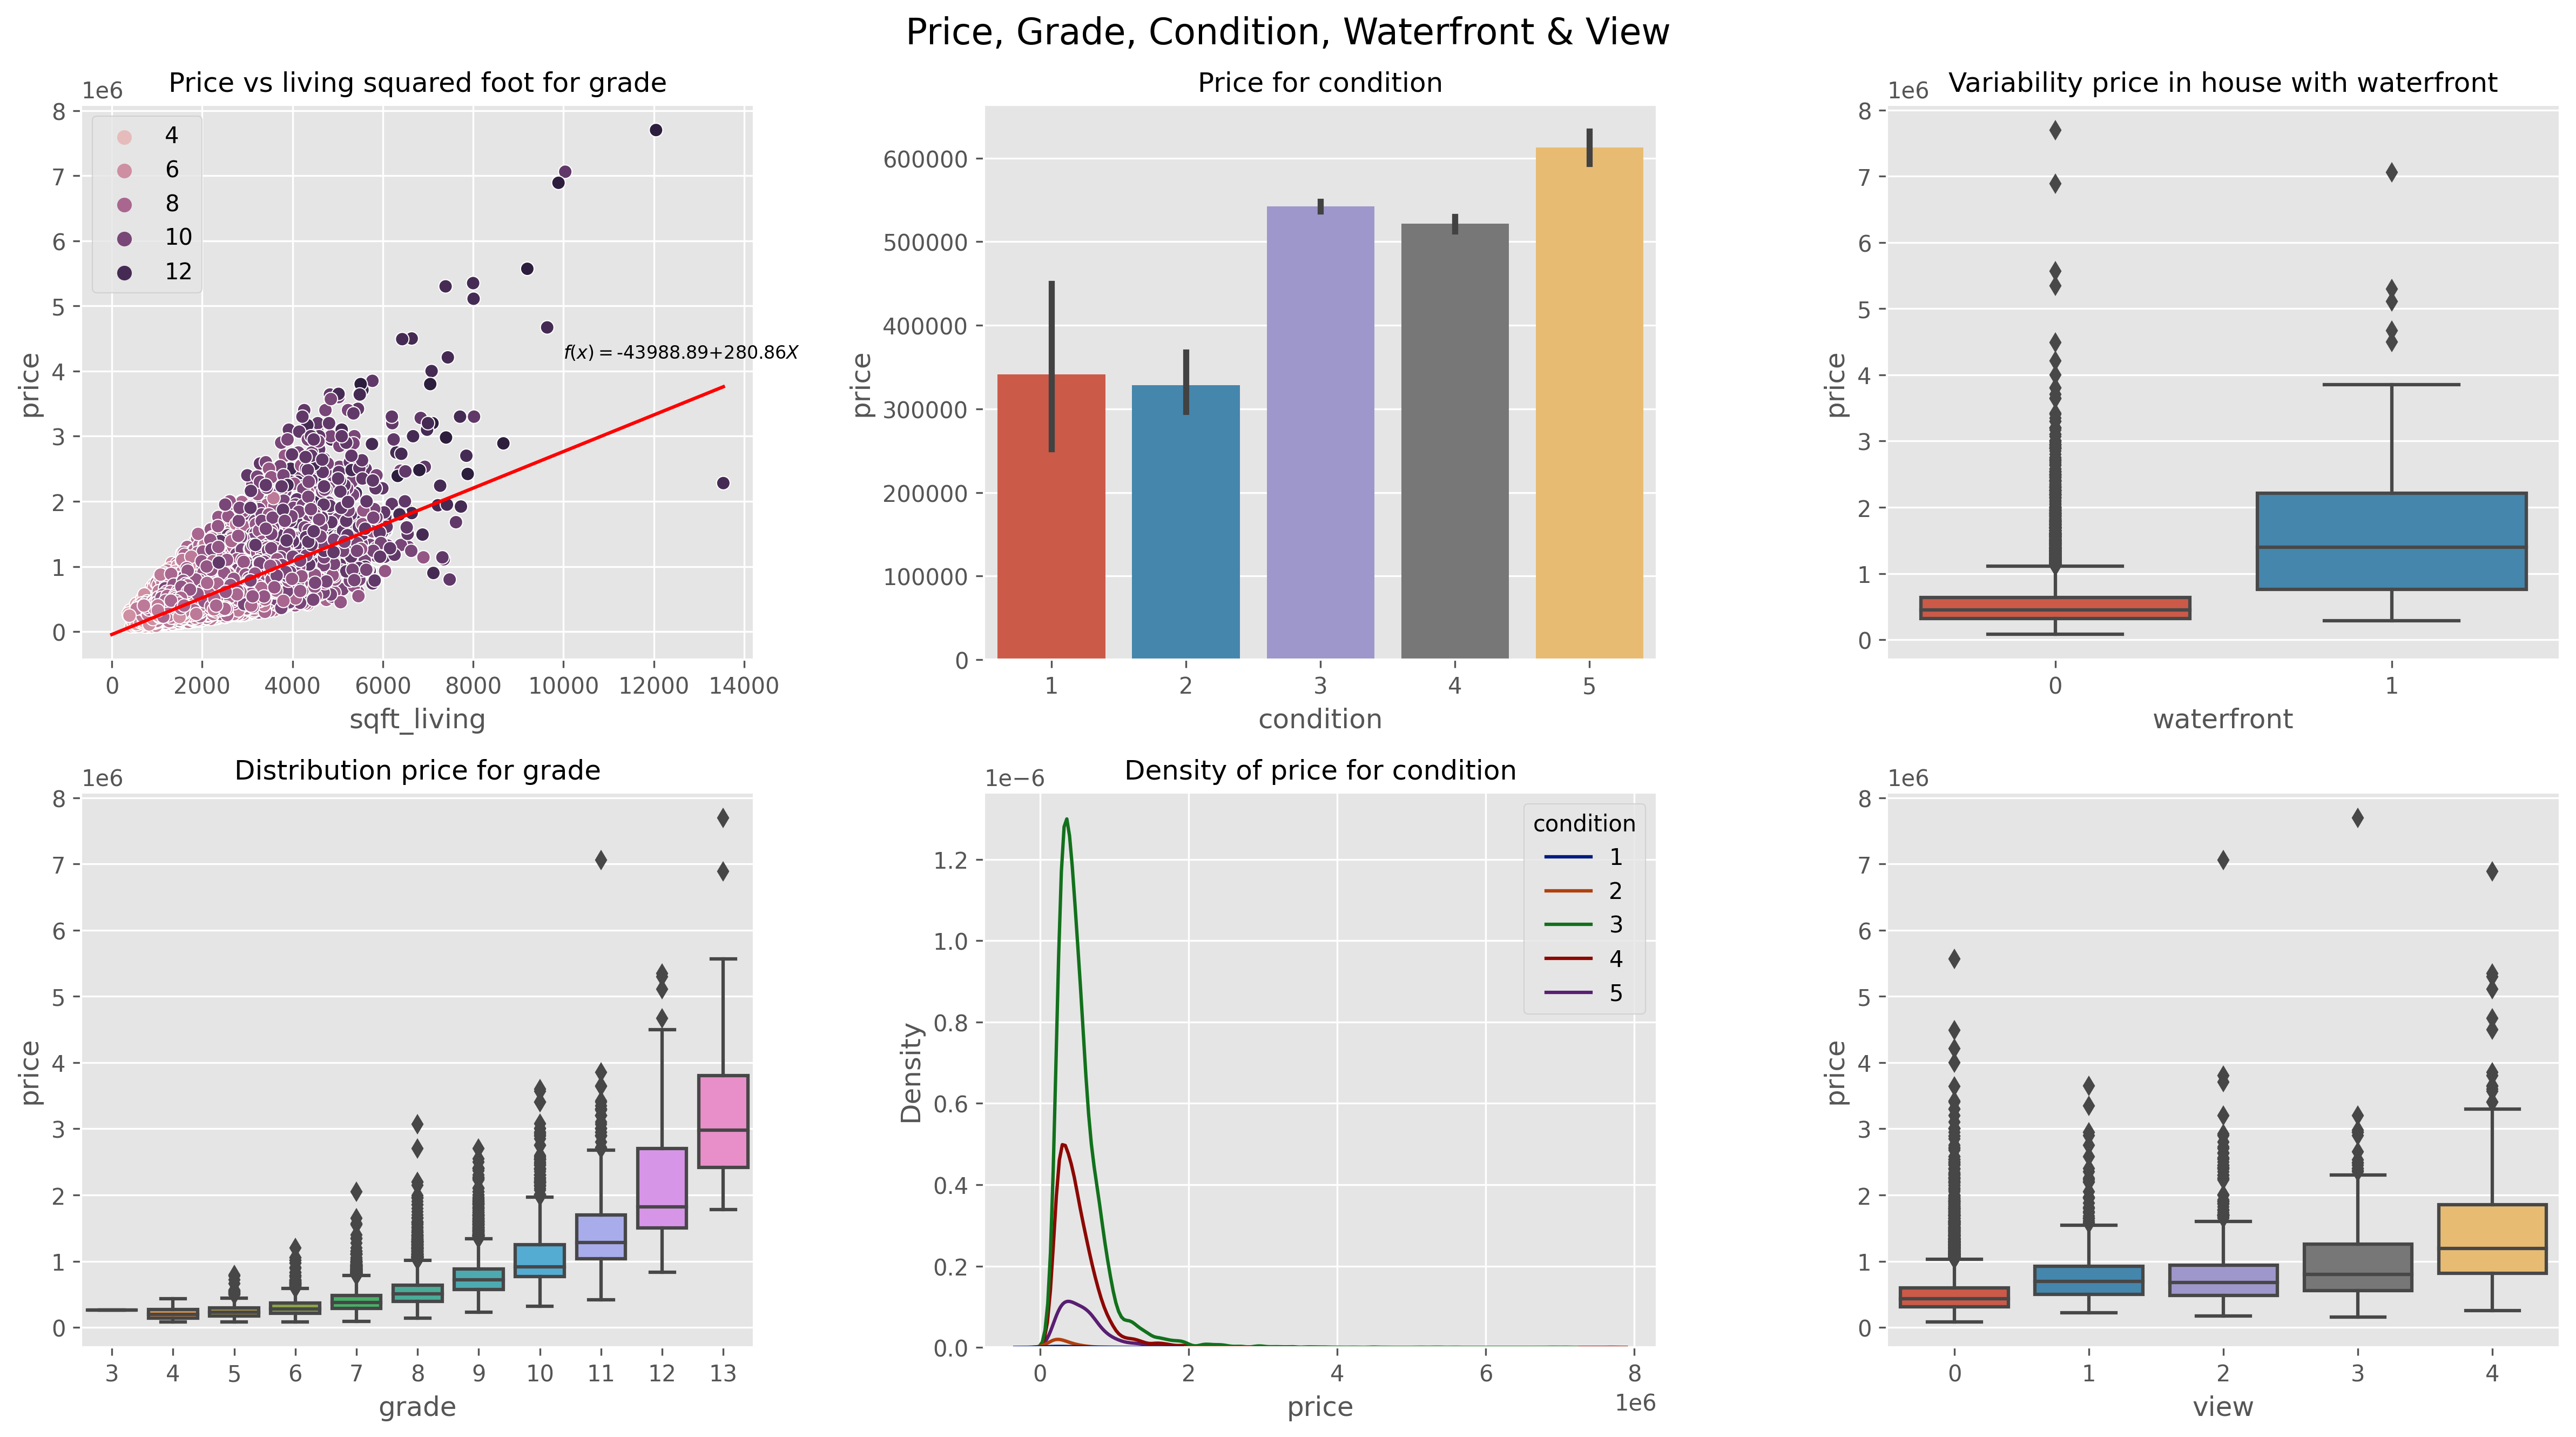

In [35]:
# Create Canvas
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 9), 
                                                        dpi = 300, tight_layout = True)

# Groupby data
condition_gb = pd.DataFrame(data.groupby('condition')['price'].mean()).reset_index()


# Plots
sns.scatterplot(x = 'sqft_living', hue = 'grade', y = 'price', data = df_plot, ax = ax1)
sns.lineplot(x = x[:,0], y = y_predict, color = 'red', ax = ax1)
ax1.text(x = 10000, y = 4.2e6, s = ecu, fontsize = 8)

sns.boxplot(x = 'grade', y = 'price', data = df_plot, ax = ax4)
sns.kdeplot(x='price', hue = 'condition', data = df_plot, cumulative=False, shade=False, palette='dark', ax=ax5)
sns.barplot(x = 'condition', y = 'price', data = df_plot, ax = ax2)
sns.boxplot(x = 'waterfront', y = 'price', data = df_plot, ax = ax3)
sns.boxplot(x = 'view', y = 'price', data = df_plot, ax = ax6)

ax1.set_title('Price vs living squared foot for grade', fontdict={'fontsize': 12})
ax2.set_title('Price for condition', fontdict={'fontsize': 12})
ax3.set_title('Variability price in house with waterfront', fontdict={'fontsize': 12})
ax4.set_title('Variability price in house with waterfront', fontdict={'fontsize': 12})
ax4.set_title('Distribution price for grade', fontdict={'fontsize': 12})
ax5.set_title('Density of price for condition', fontdict={'fontsize': 12})

fig.suptitle('Price, Grade, Condition, Waterfront & View', fontsize = 16)
plt.show()

Podemos ver una relación lineal entre el `sqft_living` y el `price` del inmueble. Se pudo realizar una modelación del mismo con una regresión simple mediante `sickit-learn` y queda mostrado cuales son sus parametros $\alpha$ y $\beta$. A su vez es facilmente observable que mayor nivel en el grado de clasificación, el precio incrementa sustancialmente aunque su dispreción es más notoria en los tramos superiores de este ranking.

Existe una viariabilidad en el precio con respecto a la peor condición y menor en condiciones cercanas al excelente. Los precios son crecientes en aquellos inmuebles que se encuentran cerca al mar. En el dataset es evidente una mayor cantidad de datos en los tramos medios.

La vista tiene influencia sobre el precio, pero no parece ser significativa.

Veamos los datos con respecto a las habitaciones, baños y el numero de pisos.

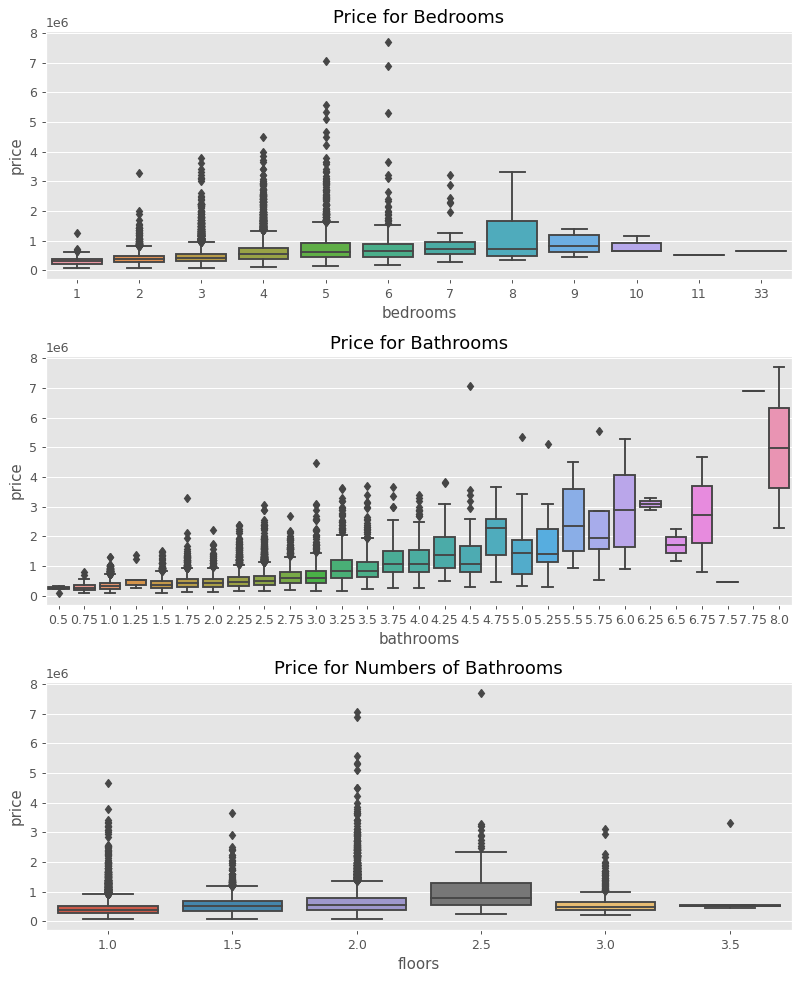

In [36]:
# Canvas
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (9, 11), dpi = 90, tight_layout = True)

#ax1
sns.boxplot(x = 'bedrooms', y = 'price', data = df_plot, ax = ax1)
ax1.set_title("Price for Bedrooms")

#ax2
sns.boxplot(x = 'bathrooms', y = 'price', data = df_plot, ax = ax2)
ax2.set_title("Price for Bathrooms")

#ax3
sns.boxplot(x = 'floors', y = 'price', data = df_plot, ax = ax3)
ax3.set_title("Price for Numbers of Bathrooms")

plt.show()

En el caso de las habitaciones, se puede ver claramente que existe una alta dispersión en el precio en aquellos inmuebles entre 3 y 7 habitaciones. Sin embargo, la media se encuentra cerca entre ellas.

En el caso de los baños si vemos una media creciente conforme aumenta el número de los mismos, por tanto si parece haber una relación entre ellos. Curiosamente no podemos decir lo mismo en el número de las plantas disponibles en la vivienda.

#### Variables vs Variables

Ya estudiamos cómo se comportan las variables con el precio objetivo (Variables independientes con Variable Dependiente). Sin embargo, antes de finalizar este examen gráfico-estadístico, es necesario saber ¿Qué hay de las correlaciones entre nuestras variables dependientes?

Este apartado es fundamental, ya que si existe una correlación entre las variables pude ocurrir un sobre ajuste en el modelo **overfiting**. Para determinar esto, es necesario visualizar gráficamente aquellas variables que intuitivamente podemos creer que existe cierta correlación y, seguido, realizar un examen numérico estadístico para evidenciar si realmente existe dicha correlación o no.

Existen varías variables que determinan los pies cuadrados de vivienda por zona, como `above` y `basement`, adicionalmente de sus versiones en 2015 de `living` y `lot`. Posiblemente una combinanción lineal entre Living y Lot pueda generar un mayor cociente entre bathrooms/betrooms, a mayor área habitable, es natural intuir que el número de habitaciones y baños disponibles en la vivienda sea mayor. Realicemos un plot para ver si esto es cierto.

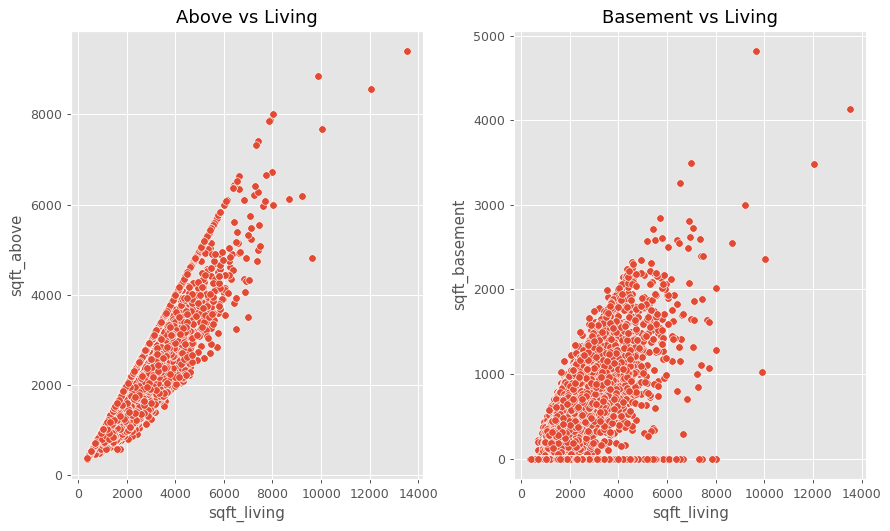

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 6), dpi = 90, tight_layout = True)

sns.scatterplot(data = df_plot, x = 'sqft_living', y = 'sqft_above', ax = ax1)
ax1.set_title('Above vs Living')
sns.scatterplot(data = df_plot, x = 'sqft_living', y = 'sqft_basement',  palette = 'Paired', ax = ax2)
ax2.set_title('Basement vs Living')

plt.show()

Vemos una clara correlación entre above y basement con living. Puede ser recomendable eliminar estas variable.

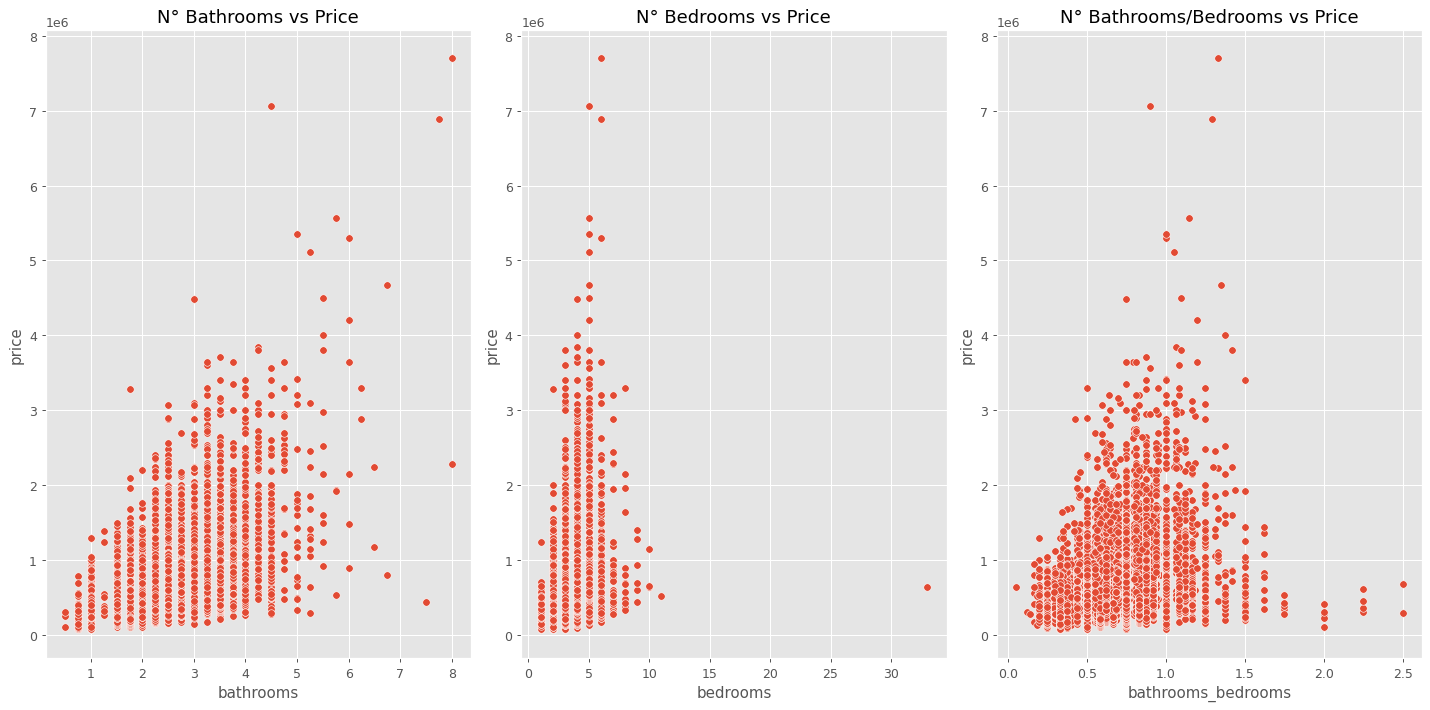

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 8), dpi = 90, tight_layout = True)

sns.scatterplot(data = df_plot, x = 'bathrooms', y = 'price', ax = ax1)
ax1.set_title('N° Bathrooms vs Price')
sns.scatterplot(data = df_plot, x = 'bedrooms', y = 'price', ax = ax2)
ax2.set_title('N° Bedrooms vs Price')

df_plot['bathrooms_bedrooms'] = df_plot['bathrooms']/df_plot['bedrooms']
sns.scatterplot(data = df_plot, x = 'bathrooms_bedrooms', y = 'price', ax = ax3)
ax3.set_title('N° Bathrooms/Bedrooms vs Price')

plt.show()

Parece haber cierta correlación entre el número de baños con respecto. realizando un cociente entre ambos elementos no vemos dicho correlació. De igual forma es necesario realizar un estudio numérico con una matriz de correlación de "Pearson" para determinar si es una correlación fuerte o suficiente como para influir en el modelo.

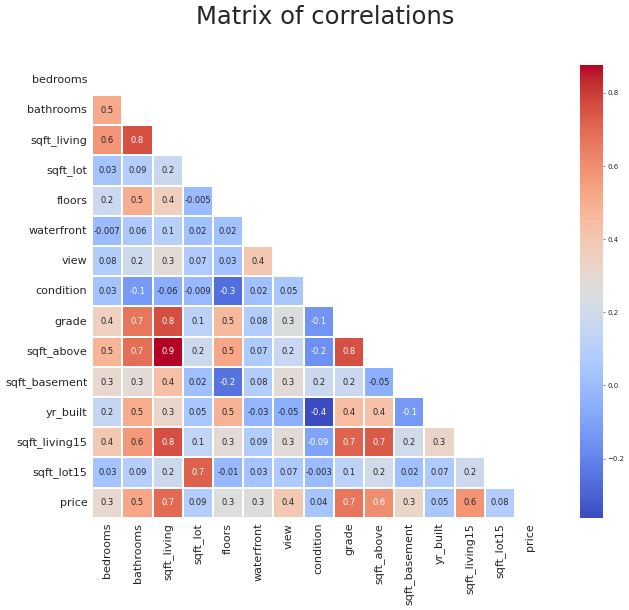

In [59]:
# correlation matrix with the Pearson method 
corr = data.drop(['id', 'date', 'yr_renovated', 'zipcode', 'lat', 'long','city'], axis = 1).corr(method='pearson')
# sns.pairplot(corr)

# We Plot a Heatmap to see this level correlation intuitively
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (18, 12), dpi = 50)
    fig.suptitle('Matrix of correlations', fontsize = 35)
    ax = sns.heatmap(corr, linewidths=0.1, annot = True,
                     annot_kws= {'size' :12}, fmt = '.1g', square = True, 
                     mask = mask, cmap = "coolwarm")
    ax.tick_params(axis = 'both', labelsize = 16)

Existen altas correlaciones de `sqft_living` con su versión de 2015 y las variables de `grade`, `sqft_above` y `bathrooms` con valores superiores a 0,7. Podemos interpretar una alta correlación entre estas variables independientes. Es necesario quedarse con aquellas que contengan mayor información sobre el target.

El caso de las `bathrooms` es mas intuitivo. Cuando aumenta el área disponible es natural pensar en un aumento del número de habitaciones y baños disponibles, aunque en este caso `bedrooms` parece tener una incidencia menor.

Con el grado de calificación puede ser esperable. Se trata de una calificación sobre la calidad de vivienda y puede ser esperable que en un aumento en el área acarré un mejor grado de calificación.

Se considera necesario realizar un proceso iterativo entre las features observadas y finalmente seleccionar una configuración que sopese una menor cantidad de sobre ajuste en el modelo.

### 2.1 Preprocesamiento

Existen variables que no entregan valor a un modelamiento o estudio estadístico. `['date', 'zipcode']` carecen de interes y pueden ser eliminadas para el modelado pero pueden ser interesantes para una visualización de los datos.

Existen campos referentes a la cantidad de pies cuadrados del living y el total tanto antes de su remodelación como la medida de referencia para el año 2015. Puede ser conveniente identificar con una variable Booleana identificando si existe una ampliación o no de estos espacios.

Adicionalmente hay varias medidas en pies cuadrados. Las mas significativas son los tamaños del Living y el lot. Los pies cuadrados de la base y el piso superior pueden ser descartados para el modelo, sin embargo como vimos en el apartado anterior, la influencia de above y basemente es considerable sobre otras variables contempladas.

In [72]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,city
0,7129300520,13/10/2014,3,1.00,1180,5650,1.0,0,0,3,...,0,1955,0,98178,47.5112,-122.257,1340,5650,221900,King County
1,6414100192,9/12/2014,3,2.25,2570,7242,2.0,0,0,3,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000,Seattle
2,5631500400,25/2/2015,2,1.00,770,10000,1.0,0,0,3,...,0,1933,0,98028,47.7379,-122.233,2720,8062,180000,Kenmore
3,2487200875,9/12/2014,4,3.00,1960,5000,1.0,0,0,5,...,910,1965,0,98136,47.5208,-122.393,1360,5000,604000,Seattle
4,1954400510,18/2/2015,3,2.00,1680,8080,1.0,0,0,3,...,0,1987,0,98074,47.6168,-122.045,1800,7503,510000,Sammamish


In [40]:
# # Remove id
# data.drop(['id'], axis = 1, inplace = True)

Realizamos las modificaciones en un nuevo dataframe, copia de la original.

In [41]:
# # Copy DataFrame
# df = data.copy()
# df.sample()

In [42]:
# # Remove Date, Zipcode
# df.drop(['zipcode', 'date', 'sqft_above', 'sqft_basement'], axis = 1, inplace=True)

In [43]:
# sqft_living and sqft_lot extended for the year 2015. Boolean
# living_ext = np.zeros((len(df), 1))
# lot_ext = np.zeros((len(df), 1))

# for i in df.index:
#     if df['sqft_living15'][i] > df['sqft_living'][i]:
#         living_ext[i] = 1
#     else:
#         living_ext[i] = 0
#     if df['sqft_lot15'][i]> df['sqft_lot'][i]:
#         lot_ext[i] = 1
#     else:
#         lot_ext[i] = 0

# df['living_ext'] = living_ext
# df['lot_ext'] = lot_ext

# # Years building


# # remove sqft_living and sqft_lot
# df.drop(['sqft_living', 'sqft_lot'], axis = 1, inplace = True)

# df.head(5)

In [44]:
# df.head()

Normalización de la Variable Objetivo

In [ ]:
from scipy import stats
from scipy.stats import skew, norm

fig, (ax1, ax2) = plt.subplots(figsize = (14, 6), nrows  = 1, ncols = 2)
    
sns.histplot(data['price'], hue_norm = norm, stat = 'frequency', kde = True, ax = ax1)
ax1.set_title("Price House Distribution")

# Calculate paramenters for normal distribution mu and sigma
(mu, sigma) = norm.fit(data['price'])
print("The Parameters mu = {:.2f} and sigma = {:.2f}".format(mu, sigma))

ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
           loc = 'best')

ax1.set_label('Frecuency')

# Get also a the probability plot in price column (variable target)
ax2 = stats.probplot(data['price'], plot = plt)

# Set title
fig.suptitle("Price before at transform", fontsize = 15)

plt.show()